In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 700)

This notebook calculates accumulated degree days (ADD) per image. Will begin with a temp. threshold of 0 deg. C.
E.g. Given a donor who has been dead for 4 days with avg. daily temps. of 4, -1, 3, and 4, the ADD = 4+3+4 = 11 deg. C.

**Note:**
- Temp. values are in degree Celcius.
- Hum. values, relative humidity, are expressed as a percent that represents the amount of water vapor in the air at a given temperature compared to the max possible water vapor amount at that same temperature. For instance, relative humidity of 25 percent means that air is at a quarter of its possible water vapor capacity.

# Import SOD-PMI-labeled data

In [3]:
# import SOD-labeled data
df_sod_pmi = pd.read_csv('../data/head/head_sod_pmi')[['path', 'label', 'old_date', 'date_placed_ARF', 'img_pmi_days']]
display(df_sod_pmi.head())
print(df_sod_pmi.shape)

,path,label,old_date,date_placed_ARF,img_pmi_days
0,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.08.JPG,2,2018-01-22,2018-01-21,1.0
1,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000129.14.JPG,2,2018-01-29,2018-01-21,8.0
2,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000213.21.JPG,2,2018-02-13,2018-01-21,23.0
3,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000219.07.JPG,3,2018-02-19,2018-01-21,29.0
4,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000222.08.JPG,3,2018-02-22,2018-01-21,32.0


(3417, 5)


In [4]:
# convert dtypes
df_sod_pmi['old_date'] = pd.to_datetime(df_sod_pmi['old_date'], format='%Y-%m-%d', errors='coerce')
df_sod_pmi['date_placed_ARF'] = pd.to_datetime(df_sod_pmi['date_placed_ARF'], format='%Y-%m-%d', errors='coerce')
df_sod_pmi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3417 entries, 0 to 3416
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   path             3417 non-null   object        
 1   label            3417 non-null   int64         
 2   old_date         3417 non-null   datetime64[ns]
 3   date_placed_ARF  3417 non-null   datetime64[ns]
 4   img_pmi_days     3417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 133.6+ KB


# Import tinytag temp/hum data

In [5]:
df_tinyt = pd.read_csv('/data/anau/temp_humidity_data/data/all_temp_hum_processed').sort_values(['date', 'time'])
display(df_tinyt.head())
print(df_tinyt.shape)
display(df_tinyt.info())

,date,time,temp_C,hum_RH
0,2014-03-14,17:31:00,17.16219,23.475
1,2014-03-14,18:31:00,16.50121,22.769
2,2014-03-14,19:31:00,15.84665,25.357
3,2014-03-14,20:31:00,15.60761,25.122
4,2014-03-14,21:31:00,15.47507,25.827


(43411, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43411 entries, 0 to 43410
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    43411 non-null  object 
 1   time    43411 non-null  object 
 2   temp_C  43411 non-null  float64
 3   hum_RH  43411 non-null  float64
dtypes: float64(2), object(2)
memory usage: 1.7+ MB


None

In [6]:
# convert dtypes
df_tinyt['date'] = pd.to_datetime(df_tinyt['date'], format='%Y-%m-%d', errors='coerce')
df_tinyt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43411 entries, 0 to 43410
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    43411 non-null  datetime64[ns]
 1   time    43411 non-null  object        
 2   temp_C  43411 non-null  float64       
 3   hum_RH  43411 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.7+ MB


In [7]:
# groupby date to calulate daily avg. temp/hum
df_tinyt_daily_avg = df_tinyt.groupby('date')[['temp_C', 'hum_RH']].mean().reset_index()
display(df_tinyt_daily_avg.head())
print(df_tinyt_daily_avg.shape)
print(df_tinyt_daily_avg.date.nunique())
display(df_tinyt_daily_avg.describe(datetime_is_numeric=True))
df_tinyt_daily_avg.info()

,date,temp_C,hum_RH
0,2014-03-14,15.243951,29.044429
1,2014-03-15,13.140941,52.316625
2,2014-03-16,9.152804,91.538708
3,2014-03-17,4.947455,100.000000
4,2014-03-18,8.896846,88.072500


(1551, 3)
1551


,date,temp_C,hum_RH
count,1551,1551.000000,1551.000000
mean,2018-03-14 04:21:49.090908928,15.934797,72.125404
min,2014-03-14 00:00:00,-7.252542,0.000000
25%,2016-01-28 12:00:00,10.216176,62.747917
50%,2019-03-01 00:00:00,16.861667,75.179167
75%,2020-05-05 12:00:00,22.707916,83.609396
max,2021-08-13 00:00:00,29.567083,100.000000
std,NaN,7.750081,17.302817


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1551 non-null   datetime64[ns]
 1   temp_C  1551 non-null   float64       
 2   hum_RH  1551 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 36.5 KB


In [8]:
# check time range of data to see what missing and will need to be filled
print(df_tinyt_daily_avg.date.dt.year.unique())

print('2014:', df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2014].date.dt.month.unique())
print('2015:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2015].date.dt.month.unique())
print('2016:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2016].date.dt.month.unique())
print('2017:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2017].date.dt.month.unique())
print('2019:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2019].date.dt.month.unique())
print('2020:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2020].date.dt.month.unique())
print('2021:',df_tinyt_daily_avg[df_tinyt_daily_avg.date.dt.year == 2021].date.dt.month.unique())

[2014 2015 2016 2017 2019 2020 2021]
2014: [3 4 5 6]
2015: [ 4  5  6  7  8  9 10 11 12]
2016: [ 1  2  3  4  5  6  7  8  9 10 11 12]
2017: [1 2]
2019: [ 2  3  4  5  6  7  8  9 10 11 12]
2020: [ 1  2  3  4  5  6  9 10 11 12]
2021: [1 2 3 4 5 6 7 8]


In [9]:
# add source column
df_tinyt_daily_avg['source'] = 'tinytag'
display(df_tinyt_daily_avg.head())
df_tinyt_daily_avg.shape

,date,temp_C,hum_RH,source
0,2014-03-14,15.243951,29.044429,tinytag
1,2014-03-15,13.140941,52.316625,tinytag
2,2014-03-16,9.152804,91.538708,tinytag
3,2014-03-17,4.947455,100.000000,tinytag
4,2014-03-18,8.896846,88.072500,tinytag


(1551, 4)

# Import LCD daily avg. temp/hum data to fill in the gaps
This data has been preprocessed in ../temp_humidity_data/.

In [11]:
df_lcd_daily_avg = pd.read_pickle('../../temp_humidity_data/data/LCD/lcd_daily_avg.pkl')
display(df_lcd_daily_avg.head())
display(df_lcd_daily_avg.info())
df_lcd_daily_avg.shape

,date,HourlyDryBulbTemperature,HourlyRelativeHumidity
0,2011-01-01,11.472727,91.803030
1,2011-01-02,3.828571,64.628571
2,2011-01-03,-0.068750,57.812500
3,2011-01-04,3.084375,60.156250
4,2011-01-05,1.008333,83.216667


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4473 entries, 0 to 4472
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      4473 non-null   datetime64[ns]
 1   HourlyDryBulbTemperature  4473 non-null   float64       
 2   HourlyRelativeHumidity    4473 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 139.8 KB


None

(4473, 3)

In [12]:
# add source column
df_lcd_daily_avg['source'] = 'lcd'
display(df_lcd_daily_avg.head())

,date,HourlyDryBulbTemperature,HourlyRelativeHumidity,source
0,2011-01-01,11.472727,91.803030,lcd
1,2011-01-02,3.828571,64.628571,lcd
2,2011-01-03,-0.068750,57.812500,lcd
3,2011-01-04,3.084375,60.156250,lcd
4,2011-01-05,1.008333,83.216667,lcd


# Merge Tinytag and LCD data
Fill in gaps of Tinytag temp/hum data with LCD temp/hum data

In [13]:
print(df_tinyt_daily_avg.dtypes)
print(df_lcd_daily_avg.dtypes)

date      datetime64[ns]
temp_C           float64
hum_RH           float64
source            object
dtype: object
date                        datetime64[ns]
HourlyDryBulbTemperature           float64
HourlyRelativeHumidity             float64
source                              object
dtype: object


In [14]:
# outer join on date column
df_temp_hum_merged = pd.merge(df_tinyt_daily_avg, df_lcd_daily_avg, on='date', how='outer')
print(df_temp_hum_merged.shape)
df_temp_hum_merged.sort_values('date', inplace=True)
display(df_temp_hum_merged.head())

(4473, 7)


,date,temp_C,hum_RH,source_x,HourlyDryBulbTemperature,HourlyRelativeHumidity,source_y
1551,2011-01-01,NaN,NaN,NaN,11.472727,91.803030,lcd
1552,2011-01-02,NaN,NaN,NaN,3.828571,64.628571,lcd
1553,2011-01-03,NaN,NaN,NaN,-0.068750,57.812500,lcd
1554,2011-01-04,NaN,NaN,NaN,3.084375,60.156250,lcd
1555,2011-01-05,NaN,NaN,NaN,1.008333,83.216667,lcd


In [15]:
# create final temp and hum columns
df_temp_hum_merged["final_temp"] = np.where(df_temp_hum_merged["temp_C"].isnull(), 
                            df_temp_hum_merged['HourlyDryBulbTemperature'], df_temp_hum_merged["temp_C"])
df_temp_hum_merged["final_hum"] = np.where(df_temp_hum_merged["hum_RH"].isnull(), 
                            df_temp_hum_merged['HourlyRelativeHumidity'], df_temp_hum_merged["hum_RH"])
df_temp_hum_merged["final_source"] = np.where(df_temp_hum_merged["source_x"].isnull(), 
                            df_temp_hum_merged['source_y'], df_temp_hum_merged["source_x"])
display(df_temp_hum_merged.head())
display(df_temp_hum_merged.info())
display(df_temp_hum_merged.describe(datetime_is_numeric=True))

,date,temp_C,hum_RH,source_x,HourlyDryBulbTemperature,HourlyRelativeHumidity,source_y,final_temp,final_hum,final_source
1551,2011-01-01,NaN,NaN,NaN,11.472727,91.803030,lcd,11.472727,91.803030,lcd
1552,2011-01-02,NaN,NaN,NaN,3.828571,64.628571,lcd,3.828571,64.628571,lcd
1553,2011-01-03,NaN,NaN,NaN,-0.068750,57.812500,lcd,-0.068750,57.812500,lcd
1554,2011-01-04,NaN,NaN,NaN,3.084375,60.156250,lcd,3.084375,60.156250,lcd
1555,2011-01-05,NaN,NaN,NaN,1.008333,83.216667,lcd,1.008333,83.216667,lcd


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4473 entries, 1551 to 4472
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      4473 non-null   datetime64[ns]
 1   temp_C                    1551 non-null   float64       
 2   hum_RH                    1551 non-null   float64       
 3   source_x                  1551 non-null   object        
 4   HourlyDryBulbTemperature  4473 non-null   float64       
 5   HourlyRelativeHumidity    4473 non-null   float64       
 6   source_y                  4473 non-null   object        
 7   final_temp                4473 non-null   float64       
 8   final_hum                 4473 non-null   float64       
 9   final_source              4473 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(3)
memory usage: 384.4+ KB


None

,date,temp_C,hum_RH,HourlyDryBulbTemperature,HourlyRelativeHumidity,final_temp,final_hum
count,4473,1551.000000,1551.000000,4473.000000,4473.000000,4473.000000,4473.000000
mean,2017-02-13 23:59:59.999999744,15.934797,72.125404,15.403488,70.956053,15.334615,71.906017
min,2011-01-01 00:00:00,-7.252542,0.000000,-13.160000,33.187500,-13.160000,0.000000
25%,2014-01-23 00:00:00,10.216176,62.747917,8.452778,61.645161,8.646875,62.781250
50%,2017-02-14 00:00:00,16.861667,75.179167,16.318750,71.421053,16.324528,73.421053
75%,2020-03-08 00:00:00,22.707916,83.609396,23.176190,80.853659,22.968750,82.326087
max,2023-03-31 00:00:00,29.567083,100.000000,31.947222,99.900000,31.947222,100.000000
std,NaN,7.750081,17.302817,8.648686,13.172007,8.508765,14.692767


In [16]:
# check time range of data make sure no gaps
print(df_temp_hum_merged.date.dt.year.unique())

print('2014:', df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2014].date.dt.month.unique())
print('2015:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2015].date.dt.month.unique())
print('2016:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2016].date.dt.month.unique())
print('2017:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2017].date.dt.month.unique())
print('2019:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2019].date.dt.month.unique())
print('2020:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2020].date.dt.month.unique())
print('2021:',df_temp_hum_merged[df_temp_hum_merged.date.dt.year == 2021].date.dt.month.unique())

[2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
2014: [ 1  2  3  4  5  6  7  8  9 10 11 12]
2015: [ 1  2  3  4  5  6  7  8  9 10 11 12]
2016: [ 1  2  3  4  5  6  7  8  9 10 11 12]
2017: [ 1  2  3  4  5  6  7  8  9 10 11 12]
2019: [ 1  2  3  4  5  6  7  8  9 10 11 12]
2020: [ 1  2  3  4  5  6  7  8  9 10 11 12]
2021: [ 1  2  3  4  5  6  7  8  9 10 11 12]


<AxesSubplot: xlabel='date'>

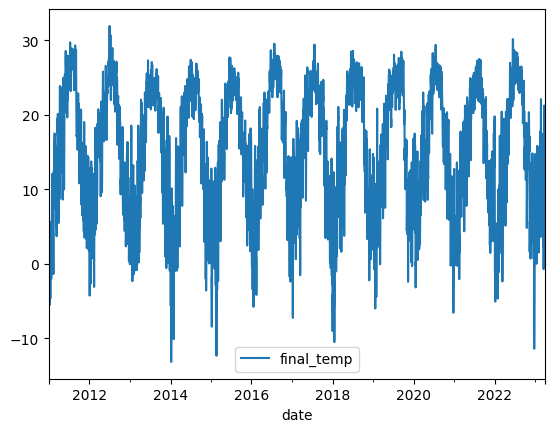

In [17]:
ax = plt.gca() 
df_temp_hum_merged.plot( x = 'date' , y = 'final_temp', ax = ax)

# Calculate ADD for each image

In [ ]:
df_dict = df_sod_pmi.to_dict('records')
for row in df_dict:
    placement_date = row['date_placed_ARF']
    img_date = row['old_date']
    
    add = 0
    start_date = placement_date
    while (start_date <= img_date):
        temp = df_temp_hum_merged[df_temp_hum_merged.date == start_date]['final_temp'].values[0]
        if temp < 0:
            temp = 0
        
        add += temp
        start_date += datetime.timedelta(days=1)
        print('date:'+str(start_date)+', temp:'+str(temp)+ ', add:'+str(add),  end="\n")
    row['add'] = add
    print()

In [19]:
df_sod_pmi_add = pd.DataFrame.from_dict(df_dict)
display(df_sod_pmi_add.head())
print(df_sod_pmi_add.shape)

,path,label,old_date,date_placed_ARF,img_pmi_days,add
0,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000122.08.JPG,2,2018-01-22,2018-01-21,1.0,18.969456
1,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000129.14.JPG,2,2018-01-29,2018-01-21,8.0,64.144508
2,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000213.21.JPG,2,2018-02-13,2018-01-21,23.0,133.226682
3,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000219.07.JPG,3,2018-02-19,2018-01-21,29.0,210.208472
4,/da1_data/icputrd/arf/mean.js/public/anau_img3/000/00000222.08.JPG,3,2018-02-22,2018-01-21,32.0,271.839059


(3417, 6)


In [21]:
df_sod_pmi_add.describe()

,label,img_pmi_days,add
count,3417.000000,3417.000000,3417.000000
mean,2.544337,40.611062,572.157320
std,1.009256,54.210218,826.716138
min,1.000000,0.000000,0.000000
25%,2.000000,10.000000,130.768497
50%,2.000000,27.000000,364.404999
75%,3.000000,54.000000,683.799106
max,4.000000,802.000000,12268.918347


In [20]:
# save data
df_sod_pmi_add.to_csv('../data/head/head_sod_pmi_add', index=False)

# ADD analysis per SOD

In [24]:
df_sod_pmi_add['date_placed_ARF'] = pd.to_datetime(df_sod_pmi_add['date_placed_ARF'], format='%Y-%m-%d', errors='coerce')

In [25]:
# split data by SOD
df_add_one = df_sod_pmi_add[df_sod_pmi_add.label == 1]
print(df_add_one.shape)
df_add_two = df_sod_pmi_add[df_sod_pmi_add.label == 2]
print(df_add_two.shape)
df_add_three = df_sod_pmi_add[df_sod_pmi_add.label == 3]
print(df_add_three.shape)
df_add_four = df_sod_pmi_add[df_sod_pmi_add.label == 4]
print(df_add_four.shape)

(518, 6)
(1319, 6)
(782, 6)
(798, 6)


### SOD 1

In [27]:
df_add_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518 entries, 6 to 3410
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   path             518 non-null    object        
 1   label            518 non-null    int64         
 2   old_date         518 non-null    datetime64[ns]
 3   date_placed_ARF  518 non-null    datetime64[ns]
 4   img_pmi_days     518 non-null    float64       
 5   add              518 non-null    float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 28.3+ KB


In [28]:
display(df_add_one.describe(datetime_is_numeric=True))

,label,old_date,date_placed_ARF,img_pmi_days,add
count,518.0,518,518,518.000000,518.000000
mean,1.0,2016-03-30 02:41:14.131274240,2016-03-20 13:48:25.019304960,9.536680,127.302731
min,1.0,2011-12-31 00:00:00,2011-12-26 00:00:00,0.000000,0.000000
25%,1.0,2014-01-11 06:00:00,2014-01-07 00:00:00,0.000000,9.791850
50%,1.0,2016-01-29 00:00:00,2016-01-11 00:00:00,1.000000,23.979545
75%,1.0,2018-01-31 00:00:00,2018-01-29 00:00:00,3.000000,44.887216
max,1.0,2021-11-19 00:00:00,2021-11-17 00:00:00,379.000000,5917.795429
std,0.0,NaN,NaN,48.396669,711.542834


### SOD 2

In [29]:
display(df_add_two.describe(datetime_is_numeric=True))

,label,old_date,date_placed_ARF,img_pmi_days,add
count,1319.0,1319,1319,1319.000000,1319.000000
mean,2.0,2015-10-01 05:30:47.763457280,2015-08-22 12:12:33.297952768,39.721001,412.885364
min,2.0,2012-01-13 00:00:00,2011-12-26 00:00:00,0.000000,0.000000
25%,2.0,2014-02-05 00:00:00,2013-12-19 00:00:00,10.000000,129.444628
50%,2.0,2015-10-21 00:00:00,2015-09-28 00:00:00,26.000000,264.730712
75%,2.0,2016-11-23 00:00:00,2016-10-27 00:00:00,56.000000,516.565161
max,2.0,2022-05-20 00:00:00,2022-05-06 00:00:00,449.000000,6297.539392
std,0.0,NaN,NaN,48.813893,622.050376


### SOD 3

In [31]:
display(df_add_three.describe(datetime_is_numeric=True))

,label,old_date,date_placed_ARF,img_pmi_days,add
count,782.0,782,782,782.000000,782.000000
mean,3.0,2016-01-25 05:35:08.439897600,2015-12-07 11:50:47.570332416,48.739130,761.550272
min,3.0,2012-02-29 00:00:00,2011-12-26 00:00:00,4.000000,39.848553
25%,3.0,2014-06-01 00:00:00,2014-05-09 00:00:00,21.000000,367.411385
50%,3.0,2016-02-26 00:00:00,2015-10-21 00:00:00,35.000000,560.081708
75%,3.0,2016-11-22 00:00:00,2016-10-14 00:00:00,58.000000,888.417695
max,3.0,2022-05-11 00:00:00,2022-04-27 00:00:00,443.000000,6443.949696
std,0.0,NaN,NaN,47.668628,725.603728


### SOD 4

In [32]:
display(df_add_four.describe(datetime_is_numeric=True))

,label,old_date,date_placed_ARF,img_pmi_days,add
count,798.0,798,798,798.000000,798.000000
mean,4.0,2015-08-24 06:29:46.466165504,2015-06-30 23:34:44.210526208,54.288221,938.584763
min,4.0,2011-08-04 00:00:00,2011-07-26 00:00:00,5.000000,86.809467
25%,4.0,2013-11-28 12:00:00,2013-10-29 00:00:00,22.000000,391.738145
50%,4.0,2014-11-14 00:00:00,2014-09-25 12:00:00,37.000000,620.877663
75%,4.0,2017-05-08 12:00:00,2017-03-09 12:00:00,67.750000,1131.481347
max,4.0,2022-05-12 00:00:00,2022-05-02 00:00:00,802.000000,12268.918347
std,0.0,NaN,NaN,63.467947,1051.130092


# Correlation analysis between SOD and ADD

In [47]:
# correlation using all quartiles
df_sod_pmi_add['label'].corr(np.log10(df_sod_pmi_add['add']+1*(10**-4)))

0.632152657867109

In [51]:
# keep only 1-3 quartiles 
df_add_one = df_add_one[df_add_one['add'] <=45].copy()
print(df_add_one.shape)
df_add_two = df_add_two[df_add_two['add'] <=517].copy()
print(df_add_two.shape)
df_add_three = df_add_three[df_add_three['add'] <=888].copy()
print(df_add_three.shape)
df_add_four = df_add_four[df_add_four['add'] <= 1131].copy()
print(df_add_four.shape)
print()
# concat into one df
df_sod_add_filtered = pd.concat([df_add_one, df_add_two, df_add_three, df_add_four])
print(df_sod_add_filtered.shape)

(356, 6)
(908, 6)
(525, 6)
(537, 6)

(2326, 6)


In [52]:
# correlation using 1-3 quartiles
df_sod_add_filtered['label'].corr(np.log10(df_sod_add_filtered['add']+1*(10**-4)))

0.6973927442627958

<AxesSubplot: xlabel='add', ylabel='label'>

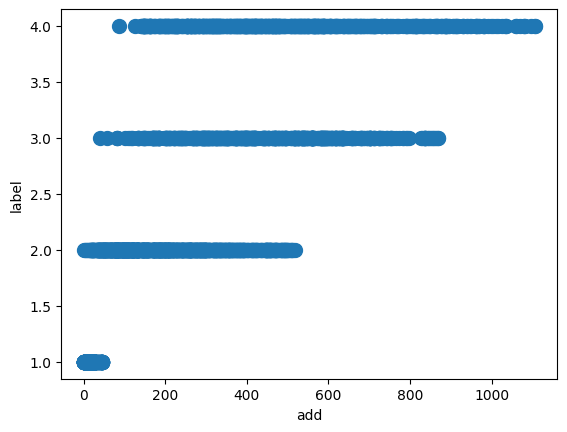

In [53]:
df_sod_add_filtered.plot.scatter(x = 'add', y = 'label', s = 100)